<a href="https://colab.research.google.com/github/dilshanindi/Bank_Marketing/blob/main/ML_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install additional required libraries
!pip install imbalanced-learn

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import files

# Upload the dataset
uploaded = files.upload()

# Load the dataset
data = pd.read_csv('bank-additional-full.csv', sep=';')
data.head()


Saving bank-additional-full.csv to bank-additional-full.csv


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# Replace 'unknown' values with NaN in categorical columns
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
data[categorical_cols] = data[categorical_cols].replace('unknown', np.nan)

# Impute missing values using mode
imputer = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = imputer.fit_transform(data[categorical_cols])

# Encode categorical variables
label_enc_cols = ['default', 'housing', 'loan', 'contact', 'poutcome', 'y']
label_encoders = {}
for col in label_enc_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# One-hot encoding for multi-category variables
data = pd.get_dummies(data, columns=['job', 'marital', 'education', 'month', 'day_of_week'], drop_first=True)

# Drop 'duration' column to prevent data leakage
data = data.drop(columns=['duration'])

# Scale numerical features
numerical_cols = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                  'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

data.head()


,age,default,housing,loan,contact,campaign,pdays,previous,poutcome,emp.var.rate,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,1.533034,0,0,0,1,-0.565922,0.195414,-0.349494,1,0.648092,...,False,False,True,False,False,False,True,False,False,False
1,1.628993,0,0,0,1,-0.565922,0.195414,-0.349494,1,0.648092,...,False,False,True,False,False,False,True,False,False,False
2,-0.290186,0,1,0,1,-0.565922,0.195414,-0.349494,1,0.648092,...,False,False,True,False,False,False,True,False,False,False
3,-0.002309,0,0,0,1,-0.565922,0.195414,-0.349494,1,0.648092,...,False,False,True,False,False,False,True,False,False,False
4,1.533034,0,0,1,1,-0.565922,0.195414,-0.349494,1,0.648092,...,False,False,True,False,False,False,True,False,False,False


In [4]:
# Separate features and target
X = data.drop(columns=['y'])
y = data['y']

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the distribution of the target variable
print("Target distribution after SMOTE:", np.bincount(y_resampled))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Target distribution after SMOTE: [36548 36548]


In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)


Training Set Shape: (58476, 45)
Testing Set Shape: (14620, 45)


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

# Create data for tabular display
results_table = [
    ["Accuracy", f"{accuracy:.4f}"],
    ["Precision", f"{precision:.4f}"],
    ["Recall", f"{recall:.4f}"],
    ["F1-Score", f"{f1:.4f}"],
    ["AUC-ROC", f"{roc_auc_rf:.4f}"]
]

# Print the table
print("Random Forest Results Table:")
print(tabulate(results_table, headers=["Metric", "Random Forest"], tablefmt="grid"))


Random Forest Results Table:
+-----------+-----------------+
| Metric    |   Random Forest |
+===========+=================+
| Accuracy  |          0.935  |
+-----------+-----------------+
| Precision |          0.9304 |
+-----------+-----------------+
| Recall    |          0.9402 |
+-----------+-----------------+
| F1-Score  |          0.9353 |
+-----------+-----------------+
| AUC-ROC   |          0.9809 |
+-----------+-----------------+


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

# Define the Neural Network model
nn_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
nn_history = nn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype(int)
y_proba_nn = nn_model.predict(X_test)

# Calculate classification metrics
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)
roc_auc_nn = roc_auc_score(y_test, y_proba_nn)

# Create data for tabular display
results_table_nn = [
    ["Accuracy", f"{accuracy_nn:.4f}"],
    ["Precision", f"{precision_nn:.4f}"],
    ["Recall", f"{recall_nn:.4f}"],
    ["F1-Score", f"{f1_nn:.4f}"],
    ["AUC-ROC", f"{roc_auc_nn:.4f}"]
]

# Print the table
print("Neural Network Results Table:")
print(tabulate(results_table_nn, headers=["Metric", "Neural Network"], tablefmt="grid"))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Neural Network Results Table:
+-----------+------------------+
| Metric    |   Neural Network |
+===========+==================+
| Accuracy  |           0.8432 |
+-----------+------------------+
| Precision |           0.8251 |
+-----------+------------------+
| Recall    |           0.8711 |
+-----------+------------------+
| F1-Score  |           0.8475 |
+-----------+------------------+
| AUC-ROC   |           0.9248 |
+-----------+------------------+


457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


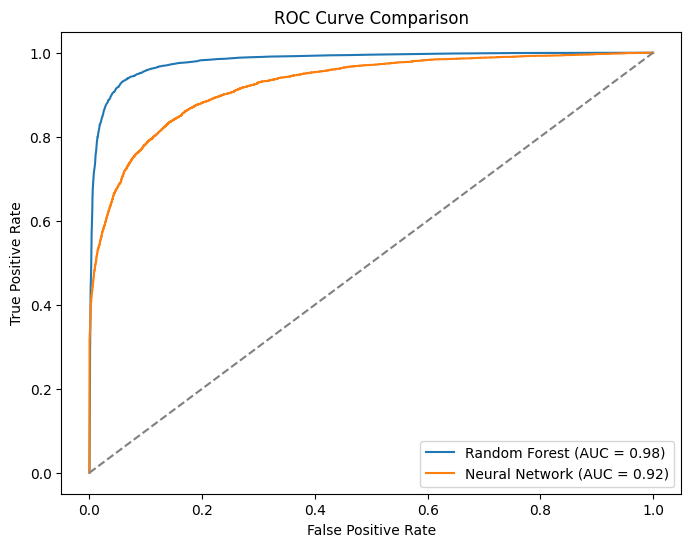

In [8]:
# Plot ROC curves
rf_probs = rf_model.predict_proba(X_test)[:, 1]
nn_probs = nn_model.predict(X_test).flatten()

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_probs)

plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot(nn_fpr, nn_tpr, label=f"Neural Network (AUC = {roc_auc_nn:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [9]:
# Save results to a CSV
results = pd.DataFrame({
    "Model": ["Random Forest", "Neural Network"],
    "AUC-ROC": [roc_auc_rf, roc_auc_nn]
})
results.to_csv('model_results.csv', index=False)

# Download the results
from google.colab import files
files.download('model_results.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>